In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from  torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
%rm -rf data

## Берем датасет CIFAR-10 и обучаем на нем ResNet50

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data/cifar10', train=True, download=True, transform=transforms.ToTensor())
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 82621253.51it/s]


Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10


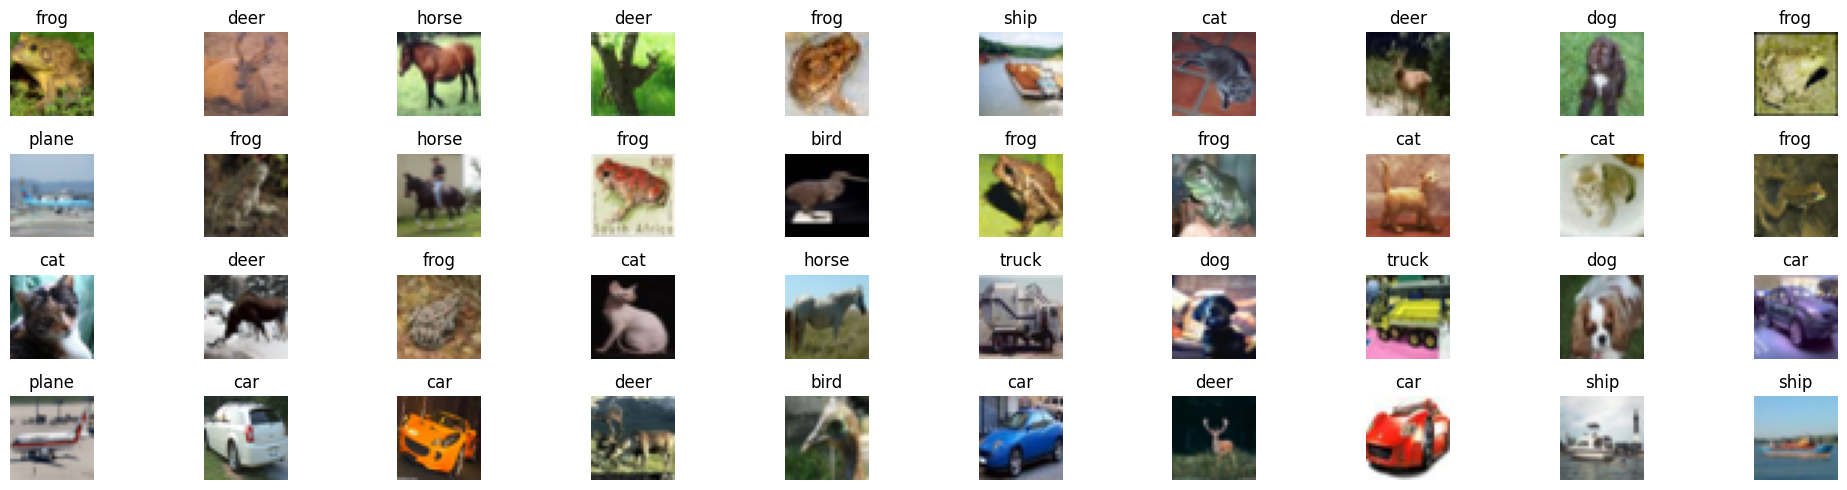

In [4]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'
def draw_sample_images(data, labels = False):
    nrows = 4
    ncols = 10

    total_image = len(data)
    samples = np.random.choice(total_image, nrows*ncols)

    plt.figure(figsize=(20, 5))
    for i in range(nrows*ncols):

        data_sample = data[samples[i]]
        image_tensor = data_sample[0].permute(1, 2, 0)
        label = classes[data_sample[1]]

        plt.subplot(nrows, ncols, i+1)
        plt.imshow(image_tensor)

        if(labels):
            plt.title(label)

        plt.axis("off")
    plt.tight_layout()
    plt.show()

draw_sample_images(trainset, labels = True)

## Подготовим входные данные (сделав нормализацию, коэффициенты - из интернета)

In [5]:
from torch.utils.data.dataloader import DataLoader

transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])
trainset = torchvision.datasets.CIFAR10(root="./data/cifar10", train=True,
                                            download=True, transform=transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                              shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root="./data/cifar10", train=False,
                                           download=True, transform=transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                             shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # Switch to train mode
    model.train()

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item() * inputs.size(0)

        # Compute training accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # Compute average training loss and accuracy
    train_loss = train_loss / len(trainloader.dataset)
    train_accuracy = 100.0 * train_correct / train_total

    return model, train_loss, train_accuracy

In [7]:
def test(model, testloader, criterion, device):
    test_loss = 0.0
    test_total = 0
    test_correct = 0

    # Switch to evaluation mode
    model.eval()

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            test_loss += loss.item() * inputs.size(0)

            # Compute test accuracy
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    # Compute average test loss and accuracy
    test_loss = test_loss / len(testloader.dataset)
    test_accuracy = 100.0 * test_correct / test_total

    return test_loss, test_accuracy

In [8]:
def train_epochs(model, trainloader, testloader, criterion, optimizer, device, num_epochs, save_interval=5):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        model, train_loss, train_accuracy = train(model, trainloader, criterion, optimizer, device)
        test_loss, test_accuracy = test(model, testloader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.2f}%')
        print(f'Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.2f}%')
        print()

        if (epoch + 1) % save_interval == 0:
          # Save the model and variables
          torch.save(model.state_dict(), f'resnet50_cifar10_{epoch+1}.pth')
          checkpoint = {
              'epoch': epoch + 1,
              'train_losses': train_losses,
              'train_accuracies': train_accuracies,
              'test_losses': test_losses,
              'test_accuracies': test_accuracies,
              'classes': classes
          }
          torch.save(checkpoint, f'resnet50_cifar10_variables_{epoch+1}.pth')

    return model, train_losses, train_accuracies, test_losses, test_accuracies


In [9]:
# Берем модельку
model = resnet50(pretrained=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 163MB/s]


In [11]:
# Само обучение
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

model, train_losses, train_accuracies, test_losses, test_accuracies = train_epochs(
          model, trainloader, testloader, criterion, optimizer, device,
          60)

Epoch 1/60
Train Loss: 2.4079 - Train Accuracy: 20.70%
Test Loss: 2.4651 - Test Accuracy: 22.71%

Epoch 2/60
Train Loss: 1.8969 - Train Accuracy: 31.65%
Test Loss: 1.6784 - Test Accuracy: 40.46%

Epoch 3/60
Train Loss: 1.6573 - Train Accuracy: 39.97%
Test Loss: 1.6360 - Test Accuracy: 44.54%

Epoch 4/60
Train Loss: 1.5242 - Train Accuracy: 44.56%
Test Loss: 1.4397 - Test Accuracy: 47.96%

Epoch 5/60
Train Loss: 1.4069 - Train Accuracy: 49.48%
Test Loss: 1.4170 - Test Accuracy: 51.81%

Epoch 6/60
Train Loss: 1.2656 - Train Accuracy: 54.69%
Test Loss: 1.1376 - Test Accuracy: 59.42%

Epoch 7/60
Train Loss: 1.1563 - Train Accuracy: 59.00%
Test Loss: 1.0695 - Test Accuracy: 62.62%

Epoch 8/60
Train Loss: 1.0439 - Train Accuracy: 63.17%
Test Loss: 1.0049 - Test Accuracy: 64.61%

Epoch 9/60
Train Loss: 0.9522 - Train Accuracy: 66.39%
Test Loss: 0.9679 - Test Accuracy: 65.95%

Epoch 10/60
Train Loss: 0.8722 - Train Accuracy: 69.35%
Test Loss: 0.9782 - Test Accuracy: 66.19%

Epoch 11/60
Train L

In [13]:
def plot_loss(train_losses, test_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(test_losses)), test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss_plot.png')
    plt.show()

In [14]:
def plot_accuracy(train_accuracies, test_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)), train_accuracies, label='Training Accuracy')
    plt.plot(range(len(test_accuracies)), test_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('accuracy_plot.png')
    plt.show()

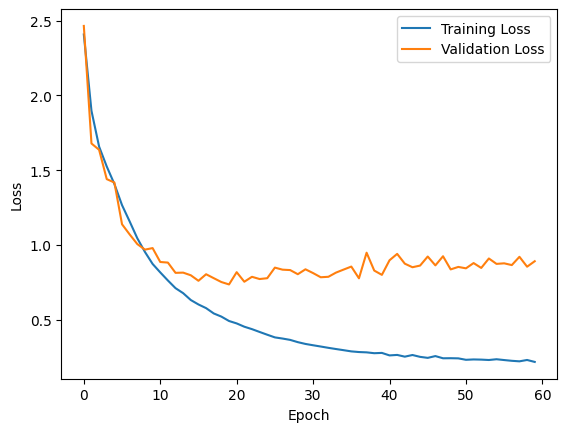

In [15]:
plot_loss(train_losses, test_losses)

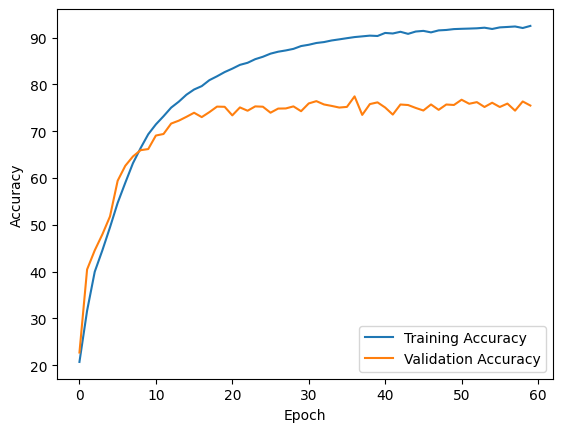

In [16]:
plot_accuracy(train_accuracies, test_accuracies)

## Как видно, моделька хорошо обучилась (точность аж 75% на тестовых данных)

In [73]:
from torchvision.transforms.functional import resize as im_resize


# Функция, которая уменьшает картинку в 4 раза, а все остальное пространство заполняет нулями
def get_multiple_images(image):
    resized_image = im_resize(image, (16, 16))
    black_image = torch.full((3, 16, 16), 0)

    horiz_1 = torch.cat((resized_image, black_image), 1)
    horiz_2 = torch.cat((black_image, black_image), 1)
    ans = torch.cat((horiz_1, horiz_2), 2)
    return ans

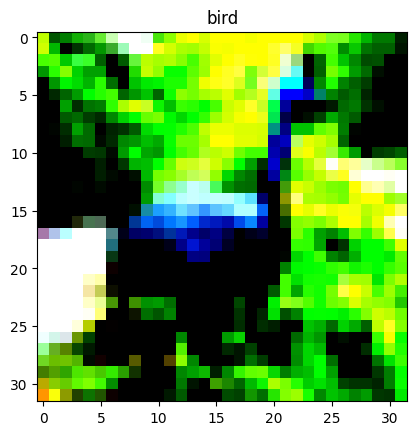

In [81]:
index = 6
test_image = trainset[index][0]
label = trainset[index][1]
plt.title(classes[label])
plt.imshow(test_image.permute(1, 2, 0))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 16, 16])
torch.Size([3, 16, 16])


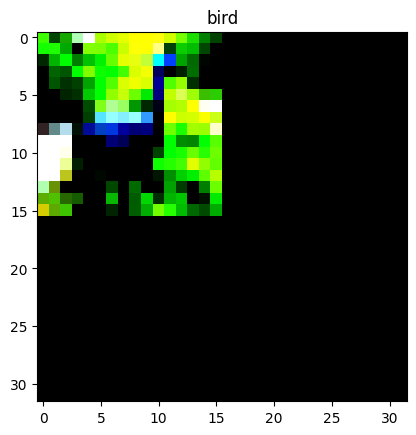

In [47]:
new_im = get_multiple_images(test_image)
plt.title(classes[label])
plt.imshow(new_im.permute(1, 2, 0))

In [74]:
testing_count = 200
samples = np.random.choice(len(trainset), testing_count)

origin_ans = []
new_ans = []
for sample_id in samples:
    origin_image = trainset[sample_id][0]
    label = trainset[sample_id][1]
    new_image = get_multiple_images(origin_image)

    origin_ans.append((origin_image, label))
    new_ans.append((new_image, label))

origin_loader = torch.utils.data.DataLoader(origin_ans, batch_size=1, shuffle=False, num_workers=1)
new_loader = torch.utils.data.DataLoader(new_ans, batch_size=1, shuffle=False, num_workers=1)

origin_loss, origin_accuracy = test(model, origin_loader, criterion, device)
new_loss, new_accuracy = test(model, new_loader, criterion, device)

In [75]:
print(f"{origin_accuracy=}\n{new_accuracy=}")

origin_accuracy=94.0
new_accuracy=15.5


## Такой результат получился с использованием сжатия изображения. Как видно, точность модели сильно уменьшилась (упала с 94% до 15%).

## Теперь попробуем применить другой фильтр - нанесем нулевую маску примерно в центр картинки (размером 5x5)

In [87]:
def apply_mask(image):
    mask = torch.full((3, 32, 32), 1)
    mask[:, 10:15, 10:15] = torch.full((3, 5, 5), 0)
    return torch.mul(mask, image)

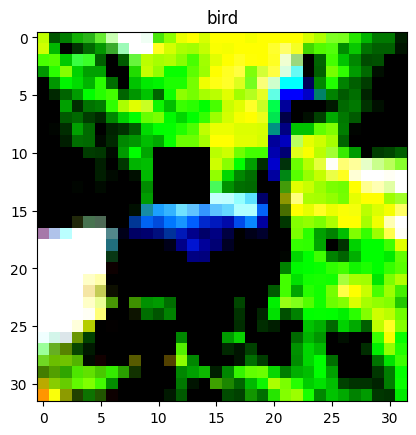

In [88]:
masked_im = apply_mask(test_image)
plt.title(classes[label])
plt.imshow(masked_im.permute(1, 2, 0))

## Тестируем весь трейн датасет на нашей модели, а также датасет с нанесенной маской

In [92]:
origin_ans = []
new_ans = []
for sample, label in trainset:
    origin_image = sample
    new_image = apply_mask(origin_image)

    origin_ans.append((origin_image, label))
    new_ans.append((new_image, label))

origin_loader = torch.utils.data.DataLoader(origin_ans, batch_size=32, shuffle=False, num_workers=2)
new_loader = torch.utils.data.DataLoader(new_ans, batch_size=32, shuffle=False, num_workers=2)

origin_loss, origin_accuracy = test(model, origin_loader, criterion, device)
new_loss, new_accuracy = test(model, new_loader, criterion, device)

In [93]:
print(f"{origin_accuracy=}\n{new_accuracy=}")

origin_accuracy=94.62
new_accuracy=90.348


## Как видно, точность с применением маски уменьшилась на 4 п.п. (И это с маской 5x5, которая закрывает всего 2.4% площади изображения)

## Попробуем проварьировать размер маски

In [109]:
def apply_mask_sized(image, mask_size):
    mask = torch.full((3, 32, 32), 1)
    center = 16 - int(mask_size / 2) - 1
    try:
        mask[:, center:center+mask_size, center:center+mask_size] = torch.full((3, mask_size, mask_size), 0)
    except:
        print(center, mask_size)
        raise ValueError()
    return torch.mul(mask, image)

In [110]:
acc_hist = []
for mask in range(1, 30):
    new_ans = []
    for image, label in trainset:
        new_image = apply_mask_sized(image, mask)
        new_ans.append((new_image, label))

    new_loader = torch.utils.data.DataLoader(new_ans, batch_size=32, shuffle=False, num_workers=2)
    new_loss, new_accuracy = test(model, new_loader, criterion, device)
    acc_hist.append(new_accuracy)

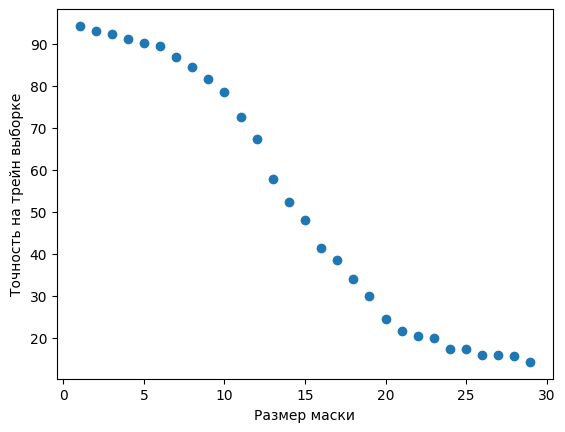

In [111]:
plt.xlabel("Размер маски")
plt.ylabel("Точность на трейн выборке")
plt.scatter(list(range(1, 30)), acc_hist)
plt.show()

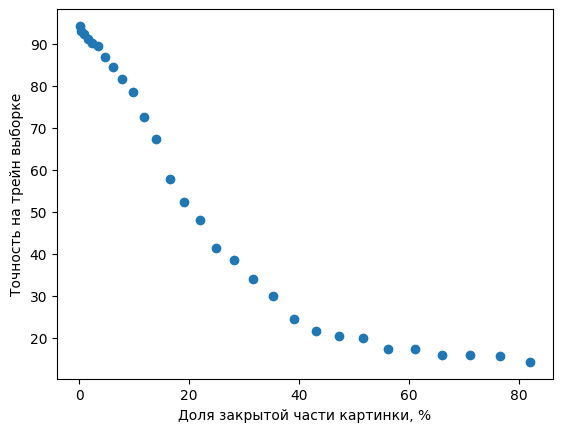

In [114]:
plt.xlabel("Доля закрытой части картинки, %")
plt.ylabel("Точность на трейн выборке")
arr = np.arange(1, 30) ** 2 / (32*32) * 100
plt.scatter(arr, acc_hist)
plt.show()

Как видно из графика, точность модели падает довольно резко с увеличением площади закрытой части картинки (при 20 процентах покрытия точность падает с 95% до 50%)